<a href="https://colab.research.google.com/github/the-bucketless/bdc/blob/main/bdc_merge_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Merging BDC Tracking Data

I've been [cleaning the tracking data](https://github.com/the-bucketless/bdc/tree/main/data) provided by Stathletes for [Big Data Cup 2022](https://github.com/bigdatacup/Big-Data-Cup-2021) and I added a game_seconds column to make it easier to merge with the play-by-play. However, it occurred to me there is still a little easter egg in the files that can cause some difficulty. So I figured I'd put together an example of how to combine the two. We'll start by taking a quick look at our troublemaker.

# Visualizing a Couple Shots

For our example, we'll grab the first shot from each of the first two powerplays of the Canada-USA game. The teams alternated powerplays in the opening period. Canada got a shot from the slot on their PP, the US fired from the point when they had the extra skater (no points will be awarded for correct guesses on that).

Since I already know what we're going to be looking at, I'm going to shortcut the way to our example. I've included images from the shots in the repo so we can compare.

In [ ]:
!pip install hockey_rink

  Created wheel for hockey-rink: filename=hockey_rink-0.1.6-py3-none-any.whl size=34688 sha256=baa2f375ba524e1e3c17a3b99d1dd3dd40ee142ca7d516916ab59417c192c538
  Stored in directory: /root/.cache/pip/wheels/8d/84/a1/c6810468585880653548efcb0dc38ed3a8987efc5f6d3c52b7
Successfully built hockey-rink


In [ ]:
from hockey_rink import BDCRink
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io

In [ ]:
pbp = pd.read_csv("https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/pxp_womens_oly_2022_v2.csv")

tracking_example_dfs = [
    pd.read_csv(
        "https://github.com/the-bucketless/bdc/raw/main/data/"
        f"2022-02-08%20Canada%20at%20USA/"
        f"2022-02-08%20Canada%20at%20USA%20P1%20PP{i}.csv"
    )
    for i in range(1, 3)
]

rink = BDCRink()

images = [
    io.imread(url)
    for url in (
        "https://github.com/the-bucketless/bdc/raw/main/images/frame-00740.jpeg",
        "https://github.com/the-bucketless/bdc/raw/main/images/01-00590.jpeg",
    )
]

In [ ]:
def get_example_shots(df):
    # the first two powerplay shots in the file happen to be the shots we're looking for
    powerplay_shots = df.loc[(df.situation_type == "5 on 4") & (df.event == "Shot")].iloc[:2]

    shot_coords = []
    powerplay_tracking = []
    for powerplay_shot, tracking_df in zip(powerplay_shots.itertuples(), tracking_example_dfs):
        tracking_df = (
            tracking_df
            .loc[tracking_df.game_seconds == powerplay_shot.clock_seconds]
            .groupby(["team_name", "jersey_number"], as_index=False)
            [["x_ft", "y_ft"]]
            .mean()
        )

        shot_coords.append((powerplay_shot.x_coord, powerplay_shot.y_coord))
        powerplay_tracking.append(tracking_df)

    return powerplay_tracking, shot_coords


powerplay_tracking, shot_coords = get_example_shots(pbp)

All right, let's take a look at what we've got. Along with all the red and blue dots for Canadian and American players, we'll display the shot location with a smaller black dot.

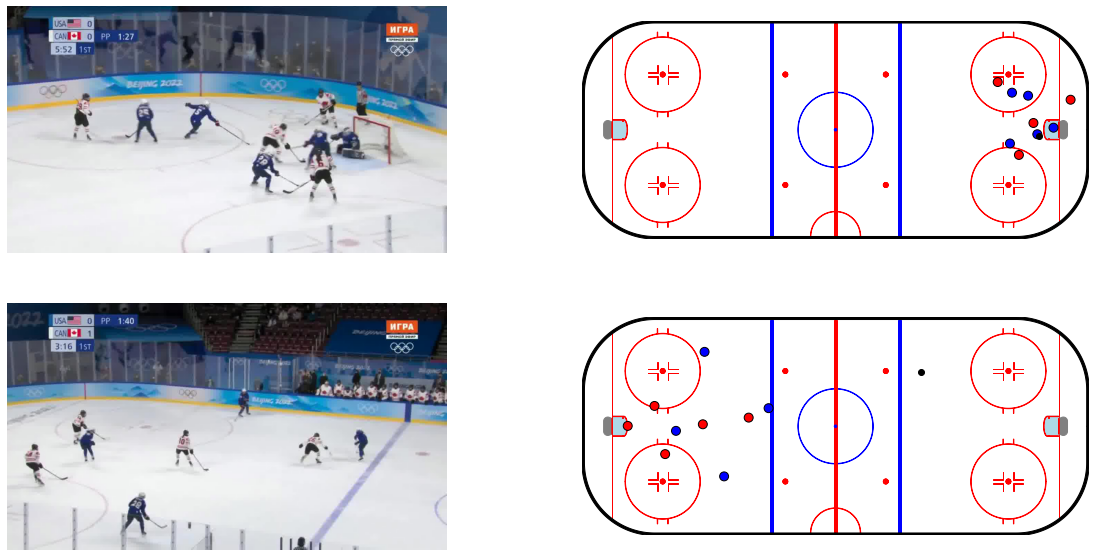

In [ ]:
def plot_example(powerplay_tracking, shot_coords):
    team_colors = {"Canada": "red", "USA": "blue"}

    fig, ax = plt.subplots(2, 2, figsize=(20, 10))

    for i, (img, tracking_df, shot_coord) in enumerate(zip(images, powerplay_tracking, shot_coords)):
        ax[i][0].imshow(img)
        ax[i][0].axis("off")

        color = powerplay_tracking[i].team_name.map(team_colors)

        rink.draw(ax=ax[i][1])
        rink.scatter(
            tracking_df.x_ft, 
            tracking_df.y_ft, 
            c=color, 
            edgecolor="black", 
            s=80, 
            ax=ax[i][1],
        )

        rink.scatter(*shot_coord, c="black", ax=ax[i][1])


plot_example(powerplay_tracking, shot_coords)

The Canadian shot is from the slot and the American shot is from ... the wrong end of the rink.  

The Stathletes play-by-play data always has the event team's coordinates listed with 0 to 100 being the defensive end of the rink and 100 to 200 being the offensive.

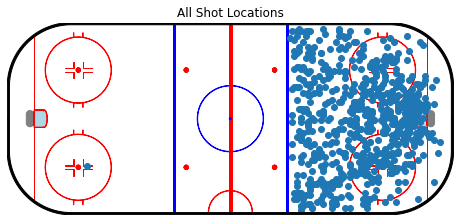

In [ ]:
def plot_shots(df, ax=None):
    if ax is None:
        ax = plt.gca()

    shots = df.loc[df.event == "Shot", ["x_coord", "y_coord"]]

    rink.draw(ax=ax)
    rink.scatter(shots.x_coord, shots.y_coord, ax=ax);


fig = plt.figure(figsize=(8, 4))
plot_shots(pbp)
plt.gca().set_title("All Shot Locations");

Whereas there is no event team in the tracking data, so coordinates are relative the camera.  

As a result, we're working on two different coordinate systems. This can make it a little more cumbersome to merge the two sets of data, but we'll manage.

# Some Data Prep

We already have the play-by-play data loaded, let's get the pp_info file. This csv provides some information to find the section of play-by-play that matches up with the tracking data.

In [ ]:
pp_info = pd.read_csv("https://github.com/bigdatacup/Big-Data-Cup-2021/raw/main/TrackingData/pp_info.csv")

Instead of using the number of seconds remaining in the period, let's convert time to number of seconds that have elapsed in the game. I prefer it this way so I don't have to remember to always check what period we're looking at. We'll have to do this in both dataframes, converting two columns in the pp_info dataframe.

In [ ]:
def convert_game_time(period, seconds):
    return 1200 * period - seconds


for prefix in ("start", "end"):
    pp_info[f"{prefix}_game_clock_seconds"] = convert_game_time(
        pp_info[f"{prefix}_period"], 
        pp_info[f"{prefix}_game_clock_seconds"]
    )

pbp["game_seconds"] = convert_game_time(pbp.period, pbp.clock_seconds)

Let's get everything to the same coordinate system. I've checked the video and every game except Canada-USA has the home team going left-to-right in odd-numbered periods. Don't know why that game's different. Probably to make life a little more difficult on us.

In any case, we have to mirror the x coordinates. I'd assumed we'd need to do the y coordinates as well, but some review of the tape says otherwise.

In [ ]:
wrong_way_teams = ["Olympic (Women) - Canada", "Olympic (Women) - United States"]
mirror_indices = (
    (
        # need to mirror the home team in even-numbered periods
        ((pbp.venue == "home") & ~(pbp.period % 2))
        # and the away team in odd-numbered
        | ((pbp.venue == "away") & (pbp.period % 2))
    )
    # flipping things in the Canada-USA game
    ^ (pbp.team_name.isin(wrong_way_teams) & pbp.opp_team_name.isin(wrong_way_teams))
)

# a rink is 200 ft long
coord_columns = ["x_coord", "x_coord_2"]
pbp.loc[mirror_indices, coord_columns] = 200 - pbp.loc[mirror_indices, coord_columns]

# Checking Our Progress

Let's take a look at the shots in each period by the home and away teams.

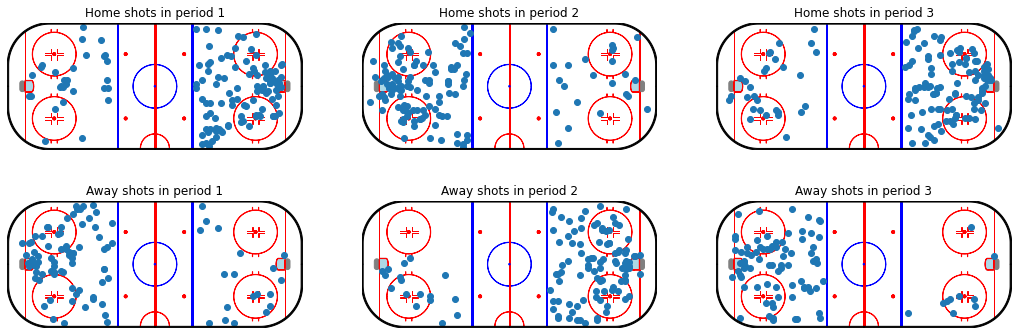

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(18, 6))

for row, venue in enumerate(("home", "away")):
    for period in range(1, 4):
        col = period - 1
        plot_shots(pbp.loc[(pbp.venue == venue) & (pbp.period == period)], axs[row, col])
        axs[row, col].set_title(f"{venue.title()} shots in period {period}")

I'll let you guess which shots came from the Canada-USA game. We'll also redo our example from the first two powerplays of Canada-USA.

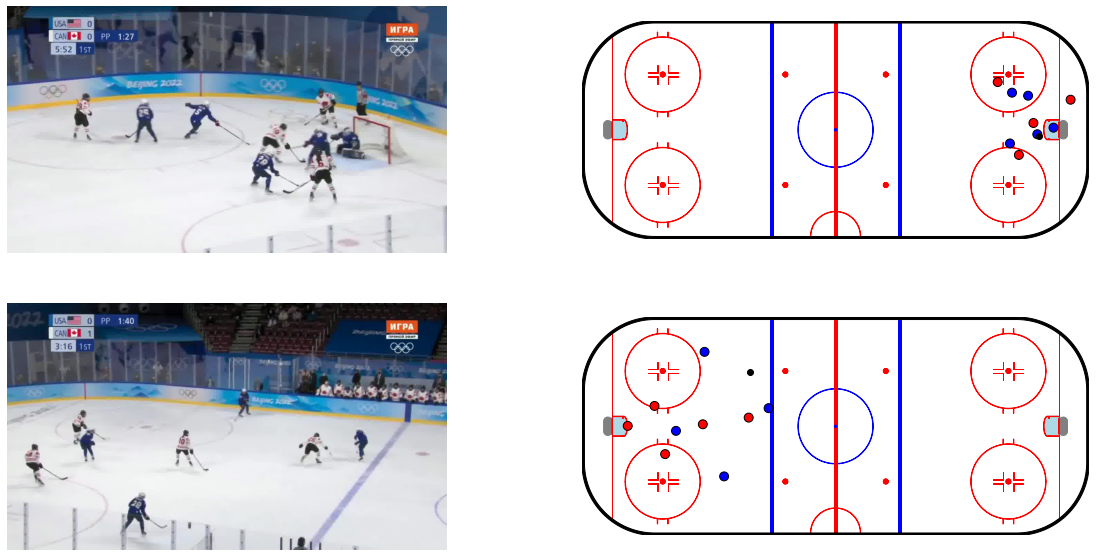

In [ ]:
plot_example(*get_example_shots(pbp))

The American D walked the blueline before the shot, so using the mean coordinates may not have been the way to go here.

# Playing with Tracking Data

We can use the following cell to choose which game of tracking data we want to work with. Some of the options provided may not have data, so check the [repo](https://github.com/the-bucketless/bdc/tree/main/data) before making a selection.

In [ ]:
game_name = "2022-02-08 Canada at USA" #@param ["2022-02-08 Canada at USA", "2022-02-08 ROC at Finland", "2022-02-12 Switzerland at ROC", "2022-02-14 USA at Finland", "2022-02-14 Switzerland at Canada", "2022-02-16 Switzerland at Finland"]
period = 1 #@param {type: "integer"}
penalty_number = 1 #@param {type: "integer"}

We'll use our selection to grab the tracking data as well as the roster for the game.

In [ ]:
game_date, away_team, _, home_team = game_name.split(" ")

roster = pd.read_csv(
    "https://github.com/bigdatacup/Big-Data-Cup-2021/raw/main/TrackingData/"
    f"{game_name.replace(' ', '%20')}/"
    f"{game_name.replace(' ', '%20')}%20roster.csv"
)

tracking = pd.read_csv(
    "https://github.com/the-bucketless/bdc/raw/main/data/"
    f"{game_name.replace(' ', '%20')}/"
    f"{game_name.replace(' ', '%20')}%20P{period}%20PP{penalty_number}.csv"
)

We have to make sure we've got time being tracked the same way as the play-by-play.

In [ ]:
tracking["game_seconds"] = convert_game_time(tracking.period, tracking.game_seconds)

And we'll want to add a couple things to the tracking data. We can determine whether a player is on the home or away team from the game selection we made and we can find their name and position in the roster file. I'm also going to get rid of the _ft part of the column names for the coordinates.

In [ ]:
tracking["venue"] = tracking.team_name.map({home_team: "home", away_team: "away"})

roster = roster.rename(columns={"jn": "jersey_number", "team": "venue"})
tracking = tracking.merge(roster, on=["venue", "jersey_number"], how="left")

tracking = tracking.rename(columns={"x_ft": "x", "y_ft": "y"})

# Merging the Data

For a lot of uses, it might be best to keep the data in two separate dataframes as we have it now. But as this is an example of how to merge the data, let's bring everything together.

For this example, we're going to add player coordinates for all the events in the play-by-play data. There are lots of different ways we could merge the data, but that seemed the easiest to me. Hopefully, the example is enough to work off of to figure out any other merge people are looking for.

To mix the tracking data with the play-by-play, we've got to get it to the right shape. Right now, the tracking data is long, with a row for each player in each frame. We'll want it to be wide, with a row for each second and columns for each player.

Since there are 30 frames in each second, we also have to decide which coordinates within a second we're associating with events. I've taken an easy route here and decided to use the average coordinates at each second. As we've already seen, this may not be the best way to go.

In [ ]:
# find the mean x and y for each player in a given second
# we keep track_id around to avoid combining multiple players missing a jersey number
tracking = (
    tracking.groupby(
        ["game_seconds", "venue", "track_id"], 
        as_index=False,
        sort=False,
    )
    .agg({
        "player": "first",
        "position": "first",
        "x": "mean",
        "y": "mean",
    })
)

# to convert rows to columns, we're going to need an index for the players and their coordinates
# this counts each player for each team at each second
tracking["player_count"] = (
    tracking
    .groupby(["game_seconds", "venue"], as_index=False, sort=False)
    .cumcount()
    + 1
)

# going from long to wide
# each second will have one row for home players and one for away
tracking = pd.pivot_table(
    tracking,
    index=["game_seconds", "venue"],
    columns="player_count",
    values=["player", "position", "x", "y"],
    aggfunc="first",
)

# combine the column name (player, position, x, or y) with its numbering
tracking.columns = [f"{col_name}_{col_number}" for col_name, col_number in tracking.columns]

# sort the columns to be player1, position1, x1, x2, player2, position2, x2, y2, ...
tracking = tracking[sorted(tracking.columns, key=lambda x: x[-1])]

# drop venue from the index
tracking = tracking.reset_index(1)

# split the dataframe into two separate dataframes for home and away
away_tracking = tracking[tracking.venue == "away"].drop(columns="venue").add_prefix("away_")
home_tracking = tracking[tracking.venue == "home"].drop(columns="venue").add_prefix("home_")

# glue them together side-by-side
tracking = away_tracking.join(home_tracking, how="outer")

With the tracking data how we want it, we're ready to merge. We'll drill down on the play-by-play to only keep the powerplay we're focusing on. Remember that missing coordinates for some events is to be expected. If the game was shot from anywhere but the center ice camera, we won't have the coordinates for that section of the video.

In [ ]:
selected_pp = pp_info[(pp_info.game_name == game_name) & (pp_info.penalty_number == penalty_number)].iloc[0]

# dates are listed in different formats in the two files
# this is to convert from yyyy-mm-dd with leading zeros to d/m/yyyy without
game_date = "/".join([str(int(x)) for x in game_date.split("-")[::-1]])

powerplay = pbp[
    (pbp.game_date == game_date)
    & (pbp.game_seconds >= selected_pp.start_game_clock_seconds)
    & (pbp.game_seconds <= selected_pp.end_game_clock_seconds)
    & (pbp.situation_type != "5 on 5")    # to get rid of the last event before the powerplay
]

powerplay = powerplay.merge(tracking, on="game_seconds", how="left")

And we can inspect the results.

In [ ]:
powerplay.head(10)

,game_date,season_year,team_name,opp_team_name,venue,period,clock_seconds,situation_type,goals_for,goals_against,player_name,event,event_successful,x_coord,y_coord,event_type,player_name_2,x_coord_2,y_coord_2,event_detail_1,event_detail_2,event_detail_3,game_seconds,away_player_1,away_position_1,away_x_1,away_y_1,away_player_2,away_position_2,away_x_2,away_y_2,away_player_3,away_position_3,away_x_3,away_y_3,away_player_4,away_position_4,away_x_4,away_y_4,away_player_5,away_position_5,away_x_5,away_y_5,home_player_1,home_position_1,home_x_1,home_y_1,home_player_2,home_position_2,home_x_2,home_y_2,home_player_3,home_position_3,home_x_3,home_y_3,home_player_4,home_position_4,home_x_4,home_y_4,home_player_5,home_position_5,home_x_5,home_y_5
0,8/2/2022,2021,Olympic (Women) - United States,Olympic (Women) - Canada,home,1,386,4 on 5,0,0,Alex Carpenter,Faceoff Win,t,169,65,Backhand,Marie-Philip Poulin,NaN,NaN,NaN,NaN,NaN,814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8/2/2022,2021,Olympic (Women) - United States,Olympic (Women) - Canada,home,1,383,4 on 5,0,0,Lee Stecklein,Puck Recovery,t,194,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8/2/2022,2021,Olympic (Women) - United States,Olympic (Women) - Canada,home,1,382,4 on 5,0,0,Lee Stecklein,Dump In/Out,f,196,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8/2/2022,2021,Olympic (Women) - Canada,Olympic (Women) - United States,away,1,380,5 on 4,0,0,Sarah Fillier,Puck Recovery,t,165,82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8/2/2022,2021,Olympic (Women) - Canada,Olympic (Women) - United States,away,1,378,5 on 4,0,0,Sarah Fillier,Play,t,194,66,Indirect,Brianne Jenner,193.0,16.0,NaN,NaN,NaN,822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,8/2/2022,2021,Olympic (Women) - Canada,Olympic (Women) - United States,away,1,375,5 on 4,0,0,Brianne Jenner,Play,t,185,7,Direct,Marie-Philip Poulin,139.0,5.0,NaN,NaN,NaN,825,Rebecca Johnston,Center,168.293063,54.857859,Brianne Jenner,Center,188.805704,70.053205,Erin Ambrose,Defense,135.895035,32.454894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lee Stecklein,Defense,177.218379,47.478171,Maddie Rooney,Goalie,185.147126,44.236636,Amanda Kessel,Center,166.148286,41.440915,Megan Keller,Defense,183.758068,61.805343,Kendall Coyne Schofield,Center,153.460106,51.567260
6,8/2/2022,2021,Olympic (Women) - Canada,Olympic (Women) - United States,away,1,373,5 on 4,0,0,Marie-Philip Poulin,Play,t,161,3,Direct,Rebecca Johnston,143.0,19.0,NaN,NaN,NaN,827,Marie-Philip Poulin,Center,157.372685,74.606901,Rebecca Johnston,Center,153.876737,56.610828,Brianne Jenner,Center,182.313659,60.465069,Erin Ambrose,Defense,129.080265,33.656513,Sarah Fillier,Center,184.886672,36.573156,Megan Keller,Defense,173.756187,59.555548,Maddie Rooney,Goalie,184.017962,47.045108,Amanda Kessel,Center,161.778338,47.203333,Kendall Coyne Schofield,Center,156.072720,66.525289,Lee Stecklein,Defense,176.263953,44.215818
7,8/2/2022,2021,Olympic (Women) - Canada,Olympic (Women) - United States,away,1,366,5 on 4,0,0,Rebecca Johnston,Play,t,176,3,Direct,Marie-Philip Poulin,130.0,17.0,NaN,NaN,NaN,834,Erin Ambrose,Defense,135.255315,35.147948,Brianne Jenner,Center,180.597495,51.749604,Rebecca Johnston,Center,174.451863,73.719136,Sarah Fillier,Center,170.708190,51.392141,Marie-Philip Poulin,Center,126.503633,64.144596,Megan Keller,Defense,174.31